Image shape: (1280, 1129, 3)
Grayscale shape: (1280, 1129)


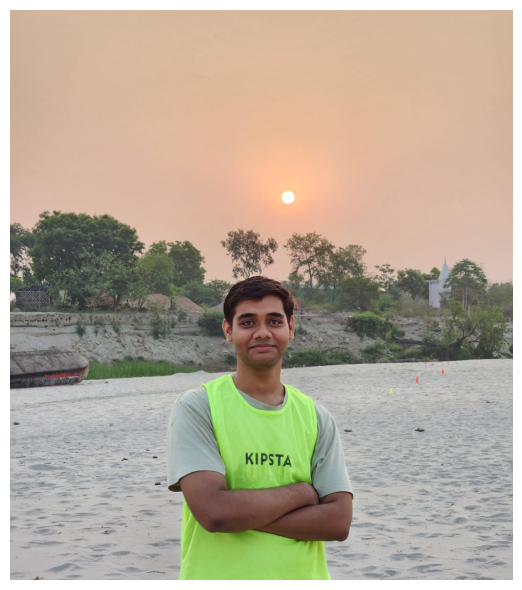

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

loaded_image = cv2.imread('/content/my_image.jpeg')

img = None
img_gray = None


img = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

print(f"Image shape: {img.shape}")
print(f"Grayscale shape: {img_gray.shape}")

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close()

def convolve(img_input, kernel):

    h, w = img_input.shape
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2
    img_padded = np.pad(img_input, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')
    output = np.zeros_like(img_input, dtype=np.float64)
    for i in range(h):
        for j in range(w):
            region = img_padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)
    return output

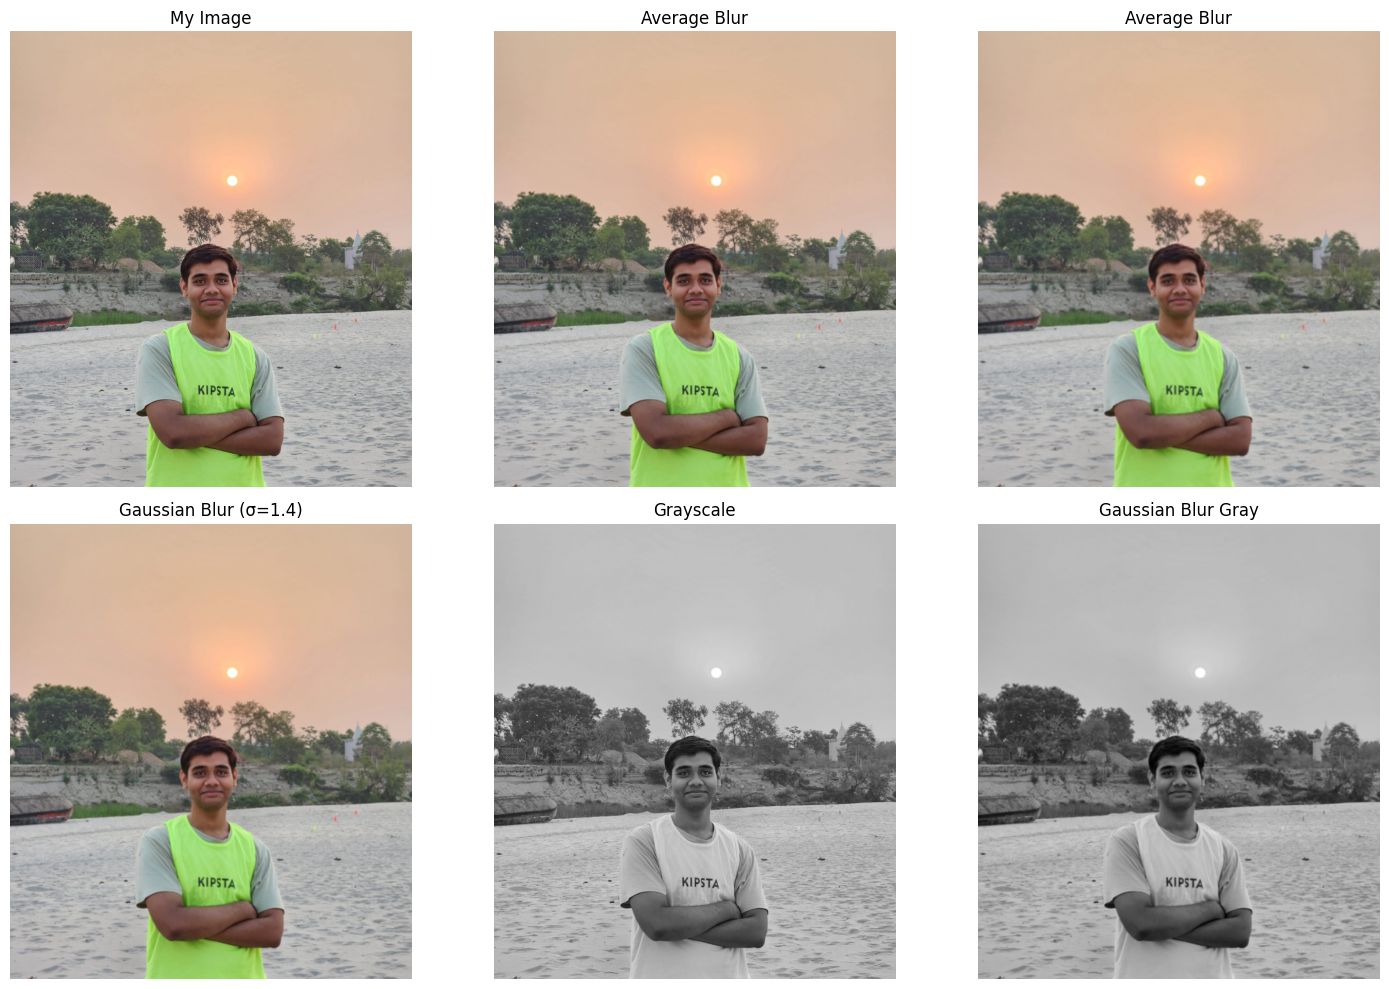

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def average_blur_gray(img, ksize):
    kernel = np.ones((ksize, ksize)) / (ksize * ksize)
    return convolve(img, kernel)

def average_blur_rgb(img, ksize):
    result = np.zeros_like(img, dtype=np.float64)
    for channel in range(3):
        result[:, :, channel] = average_blur_gray(img[:, :, channel], ksize)
    return np.clip(result, 0, 255).astype(np.uint8)

def gaussian_kernel(ksize, sigma):
    ax = np.arange(-ksize // 2 + 1, ksize // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

def gaussian_blur_gray(img, ksize, sigma):
    kernel = gaussian_kernel(ksize, sigma)
    return convolve(img, kernel)

def gaussian_blur_rgb(img, ksize, sigma):
    result = np.zeros_like(img, dtype=np.float64)
    for channel in range(3):
        result[:, :, channel] = gaussian_blur_gray(img[:, :, channel], ksize, sigma)
    return np.clip(result, 0, 255).astype(np.uint8)

blur_3x3 = average_blur_rgb(img, 3)
blur_5x5 = average_blur_rgb(img, 5)

gauss_blur_gray = gaussian_blur_gray(img_gray, 5, 1.4)
gauss_blur_rgb = gaussian_blur_rgb(img, 5, 1.4)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img)
axes[0, 0].set_title('My Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(blur_3x3)
axes[0, 1].set_title('Average Blur')
axes[0, 1].axis('off')

axes[0, 2].imshow(blur_5x5)
axes[0, 2].set_title('Average Blur')
axes[0, 2].axis('off')

axes[1, 0].imshow(gauss_blur_rgb)
axes[1, 0].set_title('Gaussian Blur (σ=1.4)')
axes[1, 0].axis('off')

axes[1, 1].imshow(img_gray, cmap='gray')
axes[1, 1].set_title('Grayscale')
axes[1, 1].axis('off')

axes[1, 2].imshow(gauss_blur_gray, cmap='gray')
axes[1, 2].set_title('Gaussian Blur Gray')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()
plt.close()

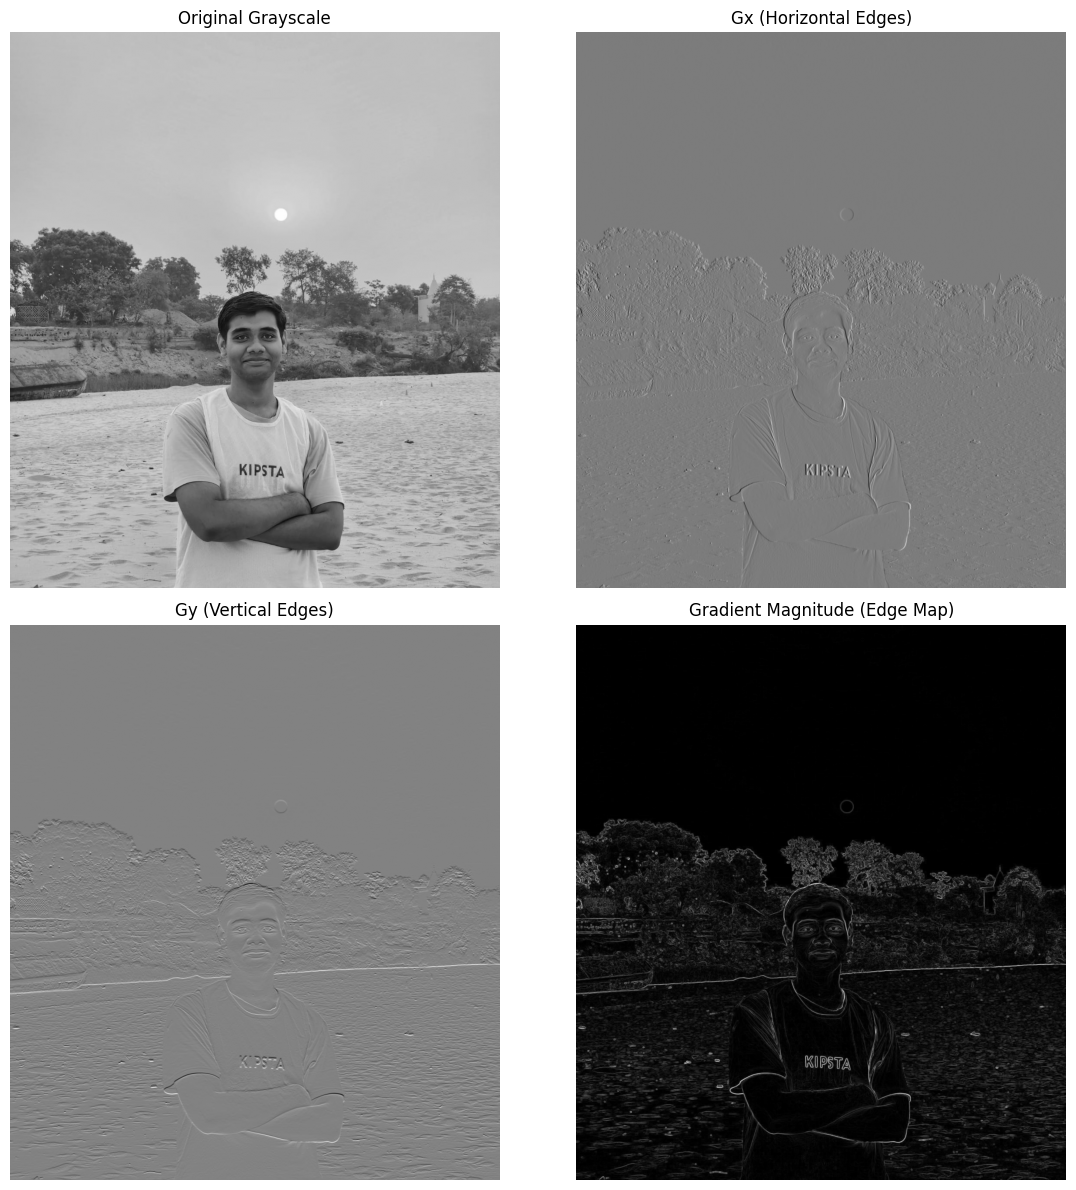

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def sobel_edge_detection(img):

    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float64)

    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]], dtype=np.float64)

    Gx = convolve(img, sobel_x)
    Gy = convolve(img, sobel_y)
    magnitude = np.sqrt(Gx**2 + Gy**2)
    return Gx, Gy, magnitude

Gx, Gy, magnitude = sobel_edge_detection(img_gray)

# Normalize magnitude to 0-255
magnitude_normalized = ((magnitude - magnitude.min()) /
                        (magnitude.max() - magnitude.min() + 1e-8) * 255).astype(np.uint8)

# Threshold the edge map (you can adjust threshold)
threshold = 50
edge_map = (magnitude_normalized > threshold).astype(np.uint8) * 255


fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('Original Grayscale')
axes[0, 0].axis('off')

axes[0, 1].imshow(Gx, cmap='gray')
axes[0, 1].set_title('Gx (Horizontal Edges)')
axes[0, 1].axis('off')

axes[1, 0].imshow(Gy, cmap='gray')
axes[1, 0].set_title('Gy (Vertical Edges)')
axes[1, 0].axis('off')

axes[1, 1].imshow(magnitude_normalized, cmap='gray')
axes[1, 1].set_title('Gradient Magnitude (Edge Map)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

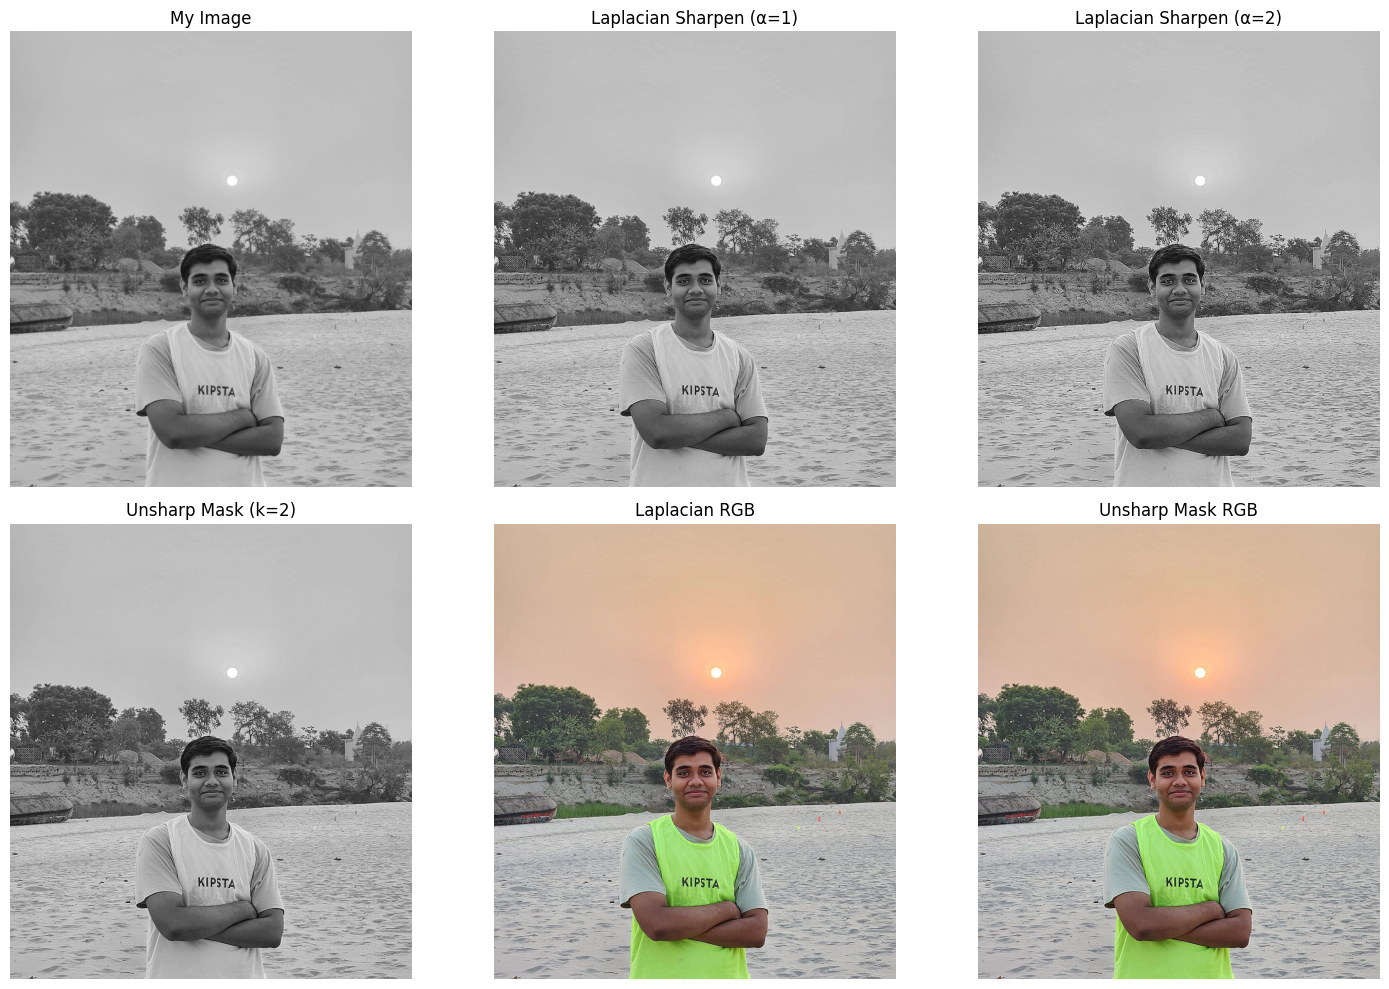

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def laplacian_sharpen(img, alpha=1.0):

    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]], dtype=np.float64)
    lap = convolve(img, laplacian_kernel)
    sharpened = img.astype(np.float64) - alpha * lap
    return np.clip(sharpened, 0, 255).astype(np.uint8), lap

sharpened_gray_alpha1, laplacian = laplacian_sharpen(img_gray, alpha=1.0)
sharpened_alpha1_cv2, _ = laplacian_sharpen(img_gray, alpha=1.0)
sharpened_alpha2_cv2, _ = laplacian_sharpen(img_gray, alpha=2.0)

sharpened_rgb = np.zeros_like(img)
for channel in range(3):
    sharpened_rgb[:, :, channel], _ = laplacian_sharpen(img[:, :, channel], alpha=1.0)

def unsharp_mask(img, k=2.0):
    """
    Apply unsharp masking
    img: grayscale/single channel image
    k: sharpening strength
    """
    blurred = gaussian_blur_gray(img, ksize=5, sigma=1.4)
    mask = img.astype(np.float64) - blurred
    sharpened = img.astype(np.float64) + k * mask
    return np.clip(sharpened, 0, 255).astype(np.uint8), mask

unsharp_gray, mask = unsharp_mask(img_gray, k=2.0)

unsharp_rgb = np.zeros_like(img)
for channel in range(3):
    unsharp_rgb[:, :, channel], _ = unsharp_mask(img[:, :, channel], k=2.0)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('My Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(sharpened_gray_alpha1, cmap='gray')
axes[0, 1].set_title('Laplacian Sharpen (α=1)')
axes[0, 1].axis('off')

axes[0, 2].imshow(sharpened_alpha2_cv2, cmap='gray')
axes[0, 2].set_title('Laplacian Sharpen (α=2)')
axes[0, 2].axis('off')

axes[1, 0].imshow(unsharp_gray, cmap='gray')
axes[1, 0].set_title('Unsharp Mask (k=2)')
axes[1, 0].axis('off')

axes[1, 1].imshow(sharpened_rgb)
axes[1, 1].set_title('Laplacian RGB')
axes[1, 1].axis('off')

axes[1, 2].imshow(unsharp_rgb)
axes[1, 2].set_title('Unsharp Mask RGB')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()
plt.close()

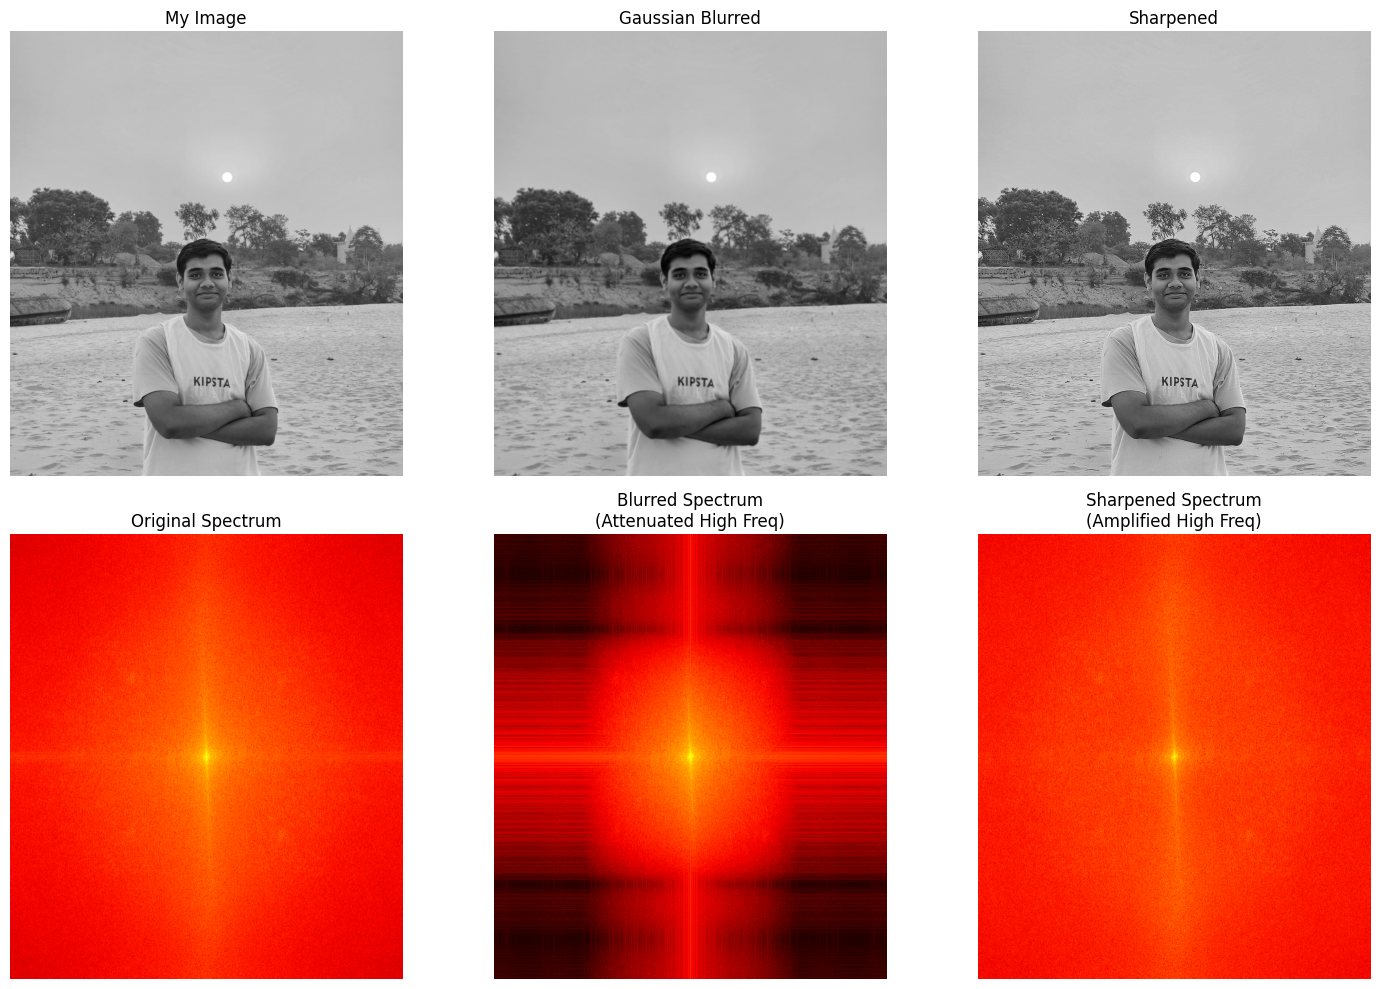


Observations:
- Gaussian blur attenuates high frequencies (edges become dim in spectrum)
- Sharpening amplifies high frequencies (edges become bright in spectrum)
- Gaussian kernel = Low-Pass Filter in frequency domain
- Sharpen kernel = High-Pass Filter in frequency domain


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def compute_magnitude_spectrum(img):

    f_transform = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    magnitude_spectrum_log = np.log(1 + magnitude_spectrum)
    return magnitude_spectrum_log

original_spectrum = compute_magnitude_spectrum(img_gray)
gausian_blurred = gaussian_blur_gray(img_gray, 5, 1.4)
gausian_spectrum = compute_magnitude_spectrum(gausian_blurred)
sharpened_spectrum = compute_magnitude_spectrum(sharpened_gray_alpha1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(img_gray, cmap='gray')
axes[0, 0].set_title('My Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(gausian_blurred, cmap='gray')
axes[0, 1].set_title('Gaussian Blurred')
axes[0, 1].axis('off')

axes[0, 2].imshow(sharpened_gray_alpha1, cmap='gray')
axes[0, 2].set_title('Sharpened')
axes[0, 2].axis('off')

axes[1, 0].imshow(original_spectrum, cmap='hot')
axes[1, 0].set_title('Original Spectrum')
axes[1, 0].axis('off')

axes[1, 1].imshow(gausian_spectrum, cmap='hot')
axes[1, 1].set_title('Blurred Spectrum\n(Attenuated High Freq)')
axes[1, 1].axis('off')

axes[1, 2].imshow(sharpened_spectrum, cmap='hot')
axes[1, 2].set_title('Sharpened Spectrum\n(Amplified High Freq)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()
plt.close()

print("\nObservations:")
print("- Gaussian blur attenuates high frequencies (edges become dim in spectrum)")
print("- Sharpening amplifies high frequencies (edges become bright in spectrum)")
print("- Gaussian kernel = Low-Pass Filter in frequency domain")
print("- Sharpen kernel = High-Pass Filter in frequency domain")

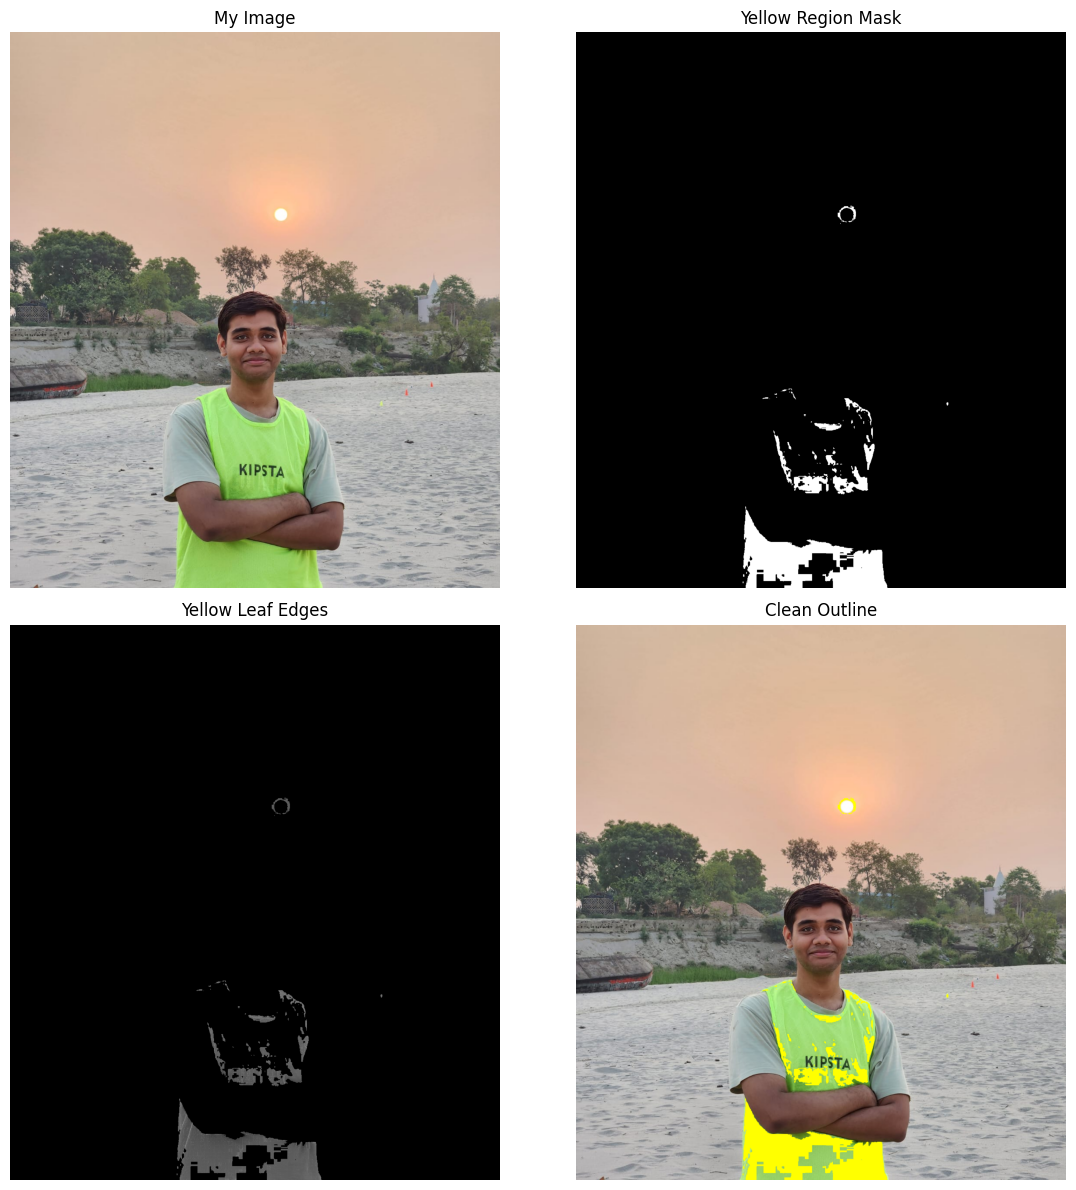

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_regions(img):

    R = img[:, :, 0].astype(np.float64)
    G = img[:, :, 1].astype(np.float64)
    B = img[:, :, 2].astype(np.float64)

    yellow_mask = ((R > 100) & (G > 100) & (B < 150) &
                   (R - B > 50) & (G - B > 50))
    return yellow_mask.astype(np.uint8) * 255

def create_custom_kernel():

    kernel_r = np.array([[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]], dtype=np.float64) / 9

    kernel_g = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]], dtype=np.float64) / 5
    return kernel_r, kernel_g

def apply_custom_kernel(img, mask):

    kernel_r, kernel_g = create_custom_kernel()

    edges_r = convolve(img[:, :, 0], kernel_r)
    edges_g = convolve(img[:, :, 1], kernel_g)

    combined_edges = np.abs(edges_r) + np.abs(edges_g)

    yellow_edges = combined_edges * (mask / 255.0)

    yellow_edges = ((yellow_edges - yellow_edges.min()) /
                    (yellow_edges.max() - yellow_edges.min() + 1e-8) * 255)
    return yellow_edges.astype(np.uint8)

yellow_mask = detect_yellow_regions(img)

yellow_edges = apply_custom_kernel(img, yellow_mask)

outline = np.zeros_like(img)
outline[yellow_edges > 30] = [255, 255, 0]

result_overlay = img.copy()
result_overlay[yellow_edges > 30] = [255, 255, 0]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

axes[0, 0].imshow(img)
axes[0, 0].set_title('My Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(yellow_mask, cmap='gray')
axes[0, 1].set_title('Yellow Region Mask')
axes[0, 1].axis('off')

axes[1, 0].imshow(yellow_edges, cmap='gray')
axes[1, 0].set_title('Yellow Leaf Edges')
axes[1, 0].axis('off')

axes[1, 1].imshow(result_overlay)
axes[1, 1].set_title('Clean Outline')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
plt.close()

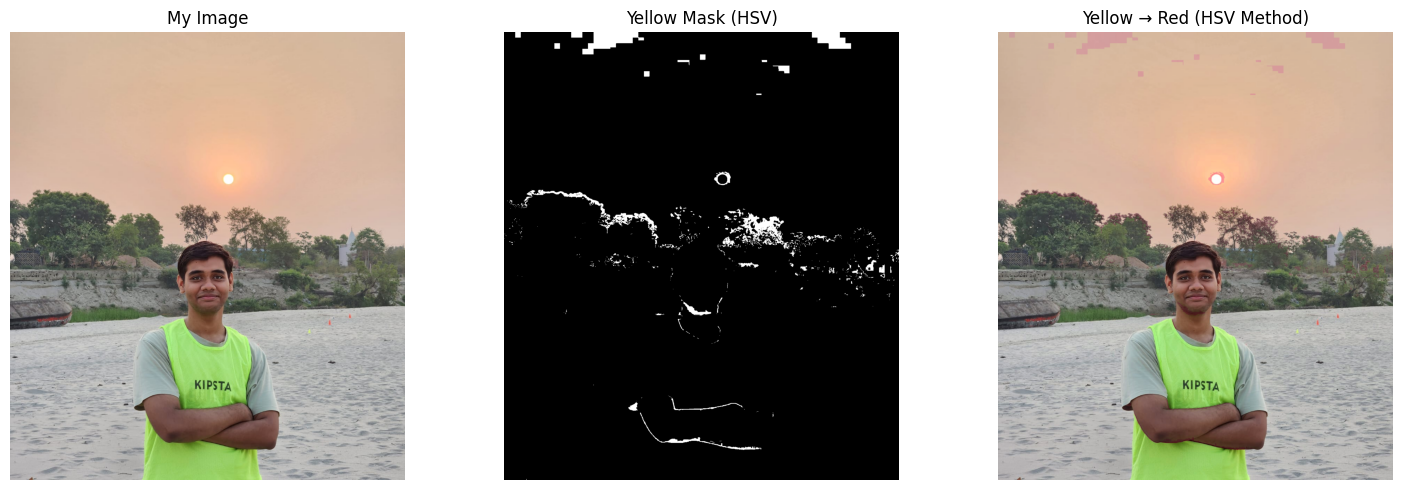

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def rgb_to_hsv_manual(rgb_img):

    hsv = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
    return hsv

def hsv_to_rgb_manual(hsv_img):
    rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb

def change_yellow_to_red(img):
    hsv = rgb_to_hsv_manual(img)
    h, s, v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]

    # In OpenCV HSV: H is 0-179, S is 0-255, V is 0-255
    # Yellow hue is around 20-30 (in 0-179 range)
    # Red hue is around 0-10 or 170-179

    yellow_mask = ((h >= 15) & (h <= 35) & (s > 50))

    h_new = h.copy()
    h_new[yellow_mask] = 0  # Set to red hue

    hsv_new = np.stack([h_new, s, v], axis=2).astype(np.uint8)

    rgb_new = hsv_to_rgb_manual(hsv_new)
    return rgb_new, yellow_mask

result_hsv, yellow_mask_hsv = change_yellow_to_red(img)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('My Image')
axes[0].axis('off')

axes[1].imshow(yellow_mask_hsv, cmap='gray')
axes[1].set_title('Yellow Mask (HSV)')
axes[1].axis('off')

axes[2].imshow(result_hsv)
axes[2].set_title('Yellow → Red (HSV Method)')
axes[2].axis('off')

plt.tight_layout()
plt.show()
plt.close()